# Tabel of Contents 

> 1. Abstract
> 2. Introduction and Motivation 
> 

# 1. Abstract 

# 2. Introduction and Motivation 

In [1]:
import os
import splitfolders 
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd

tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, MaxPooling2D, Dropout, Activation

import shutil

import cv2
import numpy as np


In [2]:
# list the folders in the directory
print(os.listdir(r"C:\1. Ob\Simulations and Data Sets\Deeplearning\data set\archive (2)"))

['flowers', 'levels', 'levels2', 'levels2.rar', 'levels3', 'resized_train', 'resized_train_cropped', 'trainLabels.csv', 'trainLabels_cropped.csv']


In [3]:
#os.mkdir('C:/1. Ob/Simulations and Data Sets/Deeplearning/data set/archive (2)/levels')


In [4]:
path = r'C:\1. Ob\Simulations and Data Sets\Deeplearning\data set\archive (2)'
labels = pd.read_csv(path+r'\trainLabels_cropped.csv')
labels

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [5]:
#for f in labels.level.unique():
#    os.mkdir('C:/1. Ob/Simulations and Data Sets/Deeplearning/data set/archive (2)/levels/{}'.format(f))


In [6]:

#for f in labels.level.unique():
    
#   df = labels.loc[labels['level'] == f]
#    l = df['image'].tolist()
#    for im in l:
#        shutil.copy(path+r'/resized_train_cropped/resized_train_cropped/{}.jpeg'.format(im), path+'/levels/{}'.format(f))
            



Width = 1024	Height = 815


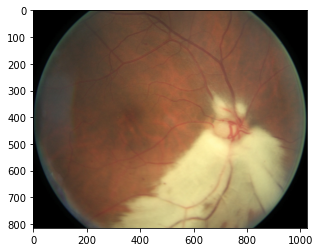

In [7]:
from PIL import Image
image1_dir = os.path.join(path+r'\levels2'+'/1/1145_left.jpeg')
img=Image.open(image1_dir)
w,h=img.size    # w=Width and h=Height
print("Width =",w,end="\t")
print("Height =",h)
import matplotlib.pyplot as plt

#show the image
plt.imshow(img)

In [8]:
root_dir=os.path.join(path+r'\levels2')
batch_size=64
img_width=256
img_height=256
print(root_dir)

C:\1. Ob\Simulations and Data Sets\Deeplearning\data set\archive (2)\levels2


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_generator(root_dir):
    
    datagen = ImageDataGenerator(rescale=1/255,
                                      #shear_range=0.2,
                                      #zoom_range=0.2,
                                      #horizontal_flip=True,
                                      #vertical_flip=True,
                                      validation_split=0.2)
  
    
    train_generator = datagen.flow_from_directory(root_dir,
                                  target_size = (img_width, img_height),
                                  batch_size = batch_size,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = datagen.flow_from_directory(root_dir,
                                 target_size=(img_width, img_height),
                                 batch_size = batch_size,
                                 class_mode = 'categorical',
                                 subset='validation')    
    
    return train_generator, test_generator

In [10]:
train_generator, test_generator = image_generator(root_dir)

Found 2800 images belonging to 5 classes.
Found 700 images belonging to 5 classes.


## Bayesian Model 1 

In [39]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3457

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(img_width, img_height,3),padding="same",filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(5)
    
])
model_bayes.summary()

C:\Users\obaid\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 256, 256, 8)       12304     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 254, 254, 64)      4672      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 128)      

In [46]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.005),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [47]:
# Training the model
history = model_bayes.fit(train_generator,
                                steps_per_epoch = train_generator.samples // batch_size,
                                validation_data = test_generator, 
                                validation_steps = test_generator.samples // batch_size,
                                epochs = 9)

Epoch 1/9
 1/43 [..............................] - ETA: 23:58 - loss: 467174.3438 - accuracy: 0.2031

KeyboardInterrupt: 

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3))
fig.suptitle("Bayesian Model 1's accuracy and Loss",fontsize=12)


ax1.plot(history1.history['accuracy'],label='train')
ax1.plot(history1.history['val_accuracy'],label='test')
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()



ax2.plot(history1.history['loss'],label='train')
ax2.plot(history1.history['val_loss'],label='test')
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend()

## Bayesian Model 2

In [15]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/train_generator.samples

model_bayes2 = tf.keras.Sequential([
    tf.keras.Input(shape=(img_width, img_height, 3),name="basket"),
    
    tfpl.Convolution2DFlipout(16, kernel_size=5, strides=(1,1), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=divergence_fn),

    MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),
    Conv2D(32, (3,3), activation='relu'),
    
    tfpl.Convolution2DFlipout(32, kernel_size=3, strides=(1,1), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1b", 
                                    kernel_divergence_fn=divergence_fn),
    MaxPool2D(strides=(4,4), pool_size=(4,4), padding="same"),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    
    Dropout(0.2),
    tfpl.DenseFlipout(units=5, kernel_divergence_fn=divergence_fn),
    #tfpl.OneHotCategorical(5)
])

learning_rate = 1.0e-3


model_bayes2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_tfp_1a (Conv2DFlipout)  (None, 256, 256, 16)      2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
conv_tfp_1b (Conv2DFlipout)  (None, 62, 62, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)         

In [16]:
def negative_log_likelihood(y_true, y_pred):
    y_pred = tfp.distributions.MultivariateNormalTriL(y_pred)
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [17]:
model_bayes2.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=learning_rate),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [18]:
# Training the model
history2 = model_bayes2.fit(train_generator,
                                steps_per_epoch = train_generator.samples // batch_size,
                                validation_data = test_generator, 
                                validation_steps = test_generator.samples // batch_size,
                                epochs = 90)

Epoch 1/90
43/43 [==============================] - 103s 2s/step - loss: 16.9902 - accuracy: 0.1750 - val_loss: 16.5482 - val_accuracy: 0.2016
Epoch 2/90
43/43 [==============================] - 99s 2s/step - loss: 16.5044 - accuracy: 0.2034 - val_loss: 16.3654 - val_accuracy: 0.1953
Epoch 3/90
43/43 [==============================] - 103s 2s/step - loss: 16.3212 - accuracy: 0.1997 - val_loss: 16.1842 - val_accuracy: 0.1734
Epoch 4/90
43/43 [==============================] - 100s 2s/step - loss: 16.1375 - accuracy: 0.1942 - val_loss: 15.9982 - val_accuracy: 0.1969
Epoch 5/90
43/43 [==============================] - 102s 2s/step - loss: 15.9533 - accuracy: 0.2029 - val_loss: 15.8139 - val_accuracy: 0.1750
Epoch 6/90
43/43 [==============================] - 100s 2s/step - loss: 15.7663 - accuracy: 0.2249 - val_loss: 15.6281 - val_accuracy: 0.1781
Epoch 7/90
43/43 [==============================] - 98s 2s/step - loss: 15.5827 - accuracy: 0.1999 - val_loss: 15.4446 - val_accuracy: 0.1859
E

KeyboardInterrupt: 

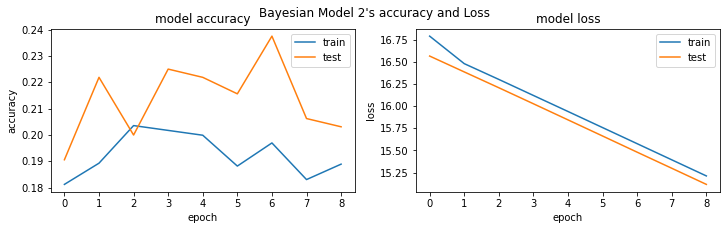

In [54]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3))
fig.suptitle("Bayesian Model 2's accuracy and Loss",fontsize=12)


ax1.plot(history2.history['accuracy'],label='train')
ax1.plot(history2.history['val_accuracy'],label='test')
ax1.title.set_text('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()



ax2.plot(history2.history['loss'],label='train')
ax2.plot(history2.history['val_loss'],label='test')
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend()


## Bayesian Model 3

In [11]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/train_generator.samples

model_bayes3 = tf.keras.Sequential([
    tf.keras.Input(shape=(img_width, img_height, 3),name="basket"),
    
    tfpl.Convolution2DFlipout(16, kernel_size=5, strides=(1,1), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=divergence_fn),
    MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    tfpl.Convolution2DFlipout(32, kernel_size=3, strides=(1,1), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1b", 
                                    kernel_divergence_fn=divergence_fn),
    MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    
    Dropout(0.2),
    tfpl.DenseFlipout(units=5, kernel_divergence_fn=divergence_fn),
    #tfpl.OneHotCategorical(5)
])

learning_rate = 1.0e-3


model_bayes3.summary()

C:\Users\obaid\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_tfp_1a (Conv2DFlipout)  (None, 256, 256, 16)      2416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 128)     18560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv_tfp_1b (Conv2DFlipout)  (None, 63, 63, 32)        73760     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       3

In [12]:
#tf.config.experimental_run_functions_eagerly(False)

from keras import backend as K

# def negative_log_likelihood(y_true, y_pred):
#     return -y_pred.log_prob(y_true)

def loss_function(y_true, y_pred):
    #tf.print(y_true-y_pred[:])
    diff=abs(y_true-y_pred[:])
    diff=diff.numpy()
    #loss=np.sum(diff, axis=1);
    loss=np.sum(diff);
    #tf.print(np.shape(np.sum(diff, axis=1)))
    return loss

# model_bayes3.compile(loss = loss_function,
#               optimizer = Adam(learning_rate=0.005),
#               metrics = ['accuracy'],
#                     run_eagerly=True,
#               experimental_run_tf_function = False)


def negative_log_likelihood(y_true, y_pred):
    #tf.print(y_pred)
    y_pred = tfp.distributions.MultivariateNormalTriL(y_pred)
    return -tf.reduce_mean(y_pred.log_prob(y_true))

from keras import backend as K

def class0(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 0), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def class1(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 1), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def class2(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 2), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def class3(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 3), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

def class4(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 4), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

In [13]:
model_bayes3.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),class0,class1,class2,class3,class4],
              experimental_run_tf_function = False)

In [ ]:
history3 = model_bayes3.fit(train_generator,
                                steps_per_epoch = train_generator.samples // batch_size,
                                validation_data = test_generator, 
                                validation_steps = test_generator.samples // batch_size,
                                epochs = 90)

Epoch 1/90
43/43 [==============================] - 264s 6s/step - loss: 41.1983 - categorical_accuracy: 0.1871 - class0: 0.2086 - class1: 0.1729 - class2: 0.1745 - class3: 0.1805 - class4: 0.2211 - val_loss: 40.9841 - val_categorical_accuracy: 0.1922 - val_class0: 0.1461 - val_class1: 0.2197 - val_class2: 0.2670 - val_class3: 0.1716 - val_class4: 0.1617
Epoch 2/90
43/43 [==============================] - 262s 6s/step - loss: 40.7817 - categorical_accuracy: 0.2069 - class0: 0.2135 - class1: 0.1809 - class2: 0.1802 - class3: 0.2224 - class4: 0.1791 - val_loss: 40.5636 - val_categorical_accuracy: 0.1969 - val_class0: 0.1917 - val_class1: 0.2264 - val_class2: 0.1924 - val_class3: 0.2548 - val_class4: 0.1343
Epoch 3/90
43/43 [==============================] - 262s 6s/step - loss: 40.3546 - categorical_accuracy: 0.2032 - class0: 0.2038 - class1: 0.1897 - class2: 0.2164 - class3: 0.1867 - class4: 0.2018 - val_loss: 40.1308 - val_categorical_accuracy: 0.2156 - val_class0: 0.1983 - val_class1:

Epoch 24/90
43/43 [==============================] - 231s 5s/step - loss: 30.5847 - categorical_accuracy: 0.2416 - class0: 0.2618 - class1: 0.2611 - class2: 0.2071 - class3: 0.2420 - class4: 0.3067 - val_loss: 30.3448 - val_categorical_accuracy: 0.2531 - val_class0: 0.2052 - val_class1: 0.2594 - val_class2: 0.2701 - val_class3: 0.2997 - val_class4: 0.2753
Epoch 25/90
43/43 [==============================] - 234s 5s/step - loss: 30.1111 - categorical_accuracy: 0.2749 - class0: 0.2453 - class1: 0.3079 - class2: 0.2474 - class3: 0.2771 - class4: 0.3087 - val_loss: 29.8733 - val_categorical_accuracy: 0.2609 - val_class0: 0.1947 - val_class1: 0.3171 - val_class2: 0.1584 - val_class3: 0.2379 - val_class4: 0.3114
Epoch 26/90
43/43 [==============================] - 233s 5s/step - loss: 29.6386 - categorical_accuracy: 0.2913 - class0: 0.2782 - class1: 0.3162 - class2: 0.2529 - class3: 0.3058 - class4: 0.3005 - val_loss: 29.4078 - val_categorical_accuracy: 0.2141 - val_class0: 0.1810 - val_clas

Epoch 47/90
43/43 [==============================] - 225s 5s/step - loss: 20.2463 - categorical_accuracy: 0.4423 - class0: 0.3846 - class1: 0.4275 - class2: 0.4070 - class3: 0.4746 - class4: 0.5194 - val_loss: 20.1122 - val_categorical_accuracy: 0.2781 - val_class0: 0.2346 - val_class1: 0.2877 - val_class2: 0.1970 - val_class3: 0.2682 - val_class4: 0.3622
Epoch 48/90
43/43 [==============================] - 221s 5s/step - loss: 19.8390 - categorical_accuracy: 0.4609 - class0: 0.4147 - class1: 0.4394 - class2: 0.4413 - class3: 0.4767 - class4: 0.5498 - val_loss: 19.7065 - val_categorical_accuracy: 0.2547 - val_class0: 0.2303 - val_class1: 0.2360 - val_class2: 0.1529 - val_class3: 0.2360 - val_class4: 0.3667
Epoch 49/90
43/43 [==============================] - 222s 5s/step - loss: 19.4336 - categorical_accuracy: 0.4722 - class0: 0.4274 - class1: 0.4505 - class2: 0.4354 - class3: 0.4524 - class4: 0.5915 - val_loss: 19.3170 - val_categorical_accuracy: 0.2547 - val_class0: 0.2275 - val_clas

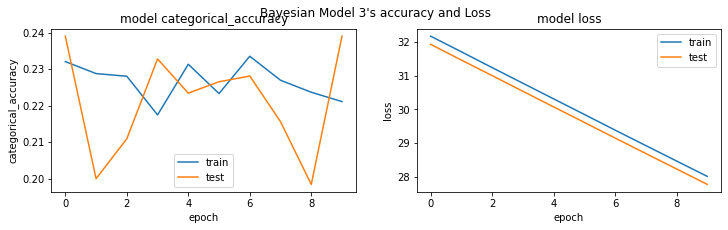

In [61]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 3))
fig.suptitle("Bayesian Model 3's accuracy and Loss",fontsize=12)


ax1.plot(history3.history['categorical_accuracy'],label='train')
ax1.plot(history3.history['val_categorical_accuracy'],label='test')
ax1.title.set_text('model categorical_accuracy')
ax1.set_ylabel('categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()



ax2.plot(history3.history['loss'],label='train')
ax2.plot(history3.history['val_loss'],label='test')
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend()

In [124]:
np.savez("history_plots.npz",history.history,history2.history,history3.history)

## 4 Display Function 1

In [62]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 5))
    predicted_probabilities2 = np.empty(shape=(300, 5))
    predicted_probabilities3 = np.empty(shape=(300, 5))
    for i in range(300):
       
        predicted_probabilities2[i] =model_bayes3.predict(img_resize[np.newaxis,...])   
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities2[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities2[:, i], 97.5) for i in range(5)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

<ipython-input-62-a17cefc3a24e>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


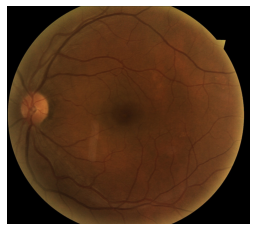

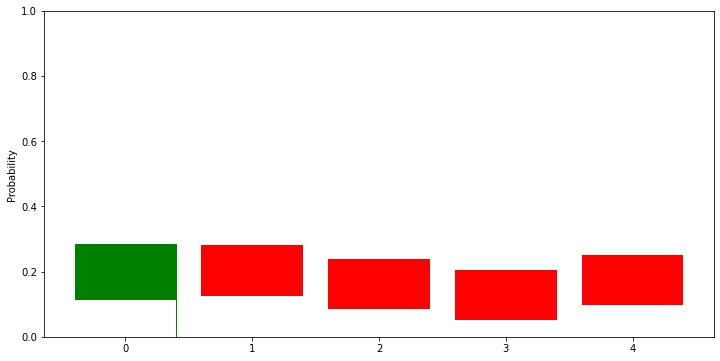

In [67]:
label = os.listdir(root_dir)
image1_dir = os.path.join(root_dir+'/1/1145_left.jpeg')
image2_dir = os.path.join(root_dir+'/0/62_left.jpeg')
image3_dir = os.path.join(root_dir+'/4/8462_right.jpeg')
image4_dir = os.path.join(root_dir+'/3/37354_right.jpeg')

prediction = import_and_predict_bayes(image2_dir,  label.index('0'))

## 5 Display Function 2

In [96]:

def import_and_predict2(image_data, label, T):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    #plt.imshow(img)
    #plt.axis('off')
    
    # resize and reshape the image
    
    img_resize = (cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
   

    prediction = model_bayes2.predict(img_reshape)    
    
    p_hat=[]
    for t in range (T):
        p_hat.append(model_bayes3.predict(img_reshape)[0])
    p_hat=np.array(p_hat)
       
    prediction = np.mean(p_hat, axis=0)
    label_prediction = label[np.argmax(prediction)]
    aleatoric = np.mean(p_hat*(1-p_hat), axis=0)
    epistemic = np.mean(p_hat**2, axis=0) - np.mean(p_hat, axis=0)**2
    
    label_prediction = [np.argmax(prediction)]
    
    return prediction, label_prediction, aleatoric, epistemic
 

['0', '1', '2', '3', '4']


In [98]:
T=10
label = os.listdir(root_dir)
image_dir = os.path.join(root_dir+'/1/1145_left.jpeg')
prediction, label_prediction, aleatoric, epistemic =import_and_predict2(image_dir, label,T)
print(epistemic)
print(label_prediction)

[0.00060333 0.00076715 0.00131298 0.00051029 0.00287569]
[3]


In [99]:
input_dir=root_dir
Class_Names=["0","1","2","3","4"]
total_prediction=np.empty(5)
total_label_prediction=np.empty(1)
total_aleatoric=np.empty(5)
total_epistemic=np.empty(5)
total_accuracy=np.empty(1)
total_tracker=np.empty(1)
tracker=np.empty(1)

for Class in Class_Names:
    path = os.path.join(input_dir,Class)
    files = os.listdir(path)
    for file in files:
        T=10 # T should be 2 or greater
        
        image_dir=os.path.join(path,file)
        #print(image_dir)
        prediction, label_prediction, aleatoric, epistemic=import_and_predict2(image_dir, label,T)                        
        total_prediction=np.vstack((total_prediction,prediction))
        total_label_prediction=np.vstack((total_label_prediction,label_prediction))
        total_aleatoric=np.vstack((total_aleatoric,aleatoric))
        total_epistemic=np.vstack((total_epistemic,epistemic))
        tracker=Class_Names.index(Class)
        total_tracker=np.vstack((total_tracker,tracker))
                            
        if(int("".join(map(str, label_prediction)))==Class_Names.index(Class)):
                total_accuracy=np.vstack((total_accuracy,1))
        else: 
                total_accuracy=np.vstack((total_accuracy,0))
        
    





In [82]:
print (total_prediction.shape)
print (total_label_prediction.shape)
print (total_aleatoric.shape)
print (total_epistemic.shape)
print (total_accuracy.shape)
print (total_tracker.shape)

(3501, 5)
(3501, 1)
(3501, 5)
(3501, 5)
(3501, 1)
(3501, 1)


In [66]:
total_prediction1=total_prediction[1:,:]
total_label_prediction1=total_label_prediction[1:,:]
total_aleatoric1=total_aleatoric[1:,:]
total_epistemic1=total_epistemic[1:,:]
total_accuracy1=total_accuracy[1:,:]
total_tracker1=total_tracker[1:,:]

In [67]:
print (total_prediction1.shape)
print (total_label_prediction1.shape)
print (total_aleatoric1.shape)
print (total_epistemic1.shape)
print (total_accuracy1.shape)
print(total_tracker1.shape)

(3500, 5)
(3500, 1)
(3500, 5)
(3500, 5)
(3500, 1)
(3500, 1)


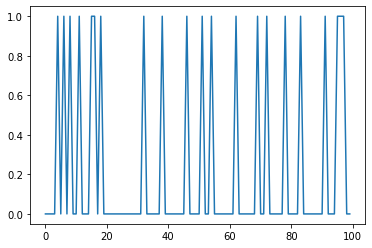

In [73]:
plt.plot(total_accuracy1[700:800,:])
#plt.plot(total_tracker1)
#plt.plot(total_accuracy1)

In [100]:
np.savez("dataDR_bayes3_700.npz",total_prediction1,total_label_prediction1,total_aleatoric1,total_epistemic1,total_accuracy1,total_tracker1)